Michael Muschitiello // AI in Asset Management // 

## Project - Black Litterman Model

 
 - Implementation of the Black-Litterman model for portfolio optimization using 1 year of daily prices for SPY, AAPL, BTC, ETH, NVDA


In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf 
from scipy.optimize import minimize

In [3]:
tickers = ['^SPX','AAPL','BTC-USD','ETH-USD','NVDA']
daily_data = pd.DataFrame()

for ticker in tickers:
    data=yf.download(ticker, period = '1y', interval = '1d')
    close_data = data['Close']
    daily_data = pd.concat([daily_data, close_data], axis=1)

daily_data = daily_data.dropna()
daily_data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ticker,^SPX,AAPL,BTC-USD,ETH-USD,NVDA
Date,,,,,
2024-03-19,5178.509766,175.252502,61912.773438,3157.618164,89.368645
2024-03-20,5224.620117,177.830307,67913.671875,3513.393066,90.342316
2024-03-21,5241.529785,170.564621,65491.390625,3492.991211,91.404961
2024-03-22,5234.180176,171.470337,63778.761719,3333.687988,94.258034
2024-03-25,5218.189941,170.047089,69958.812500,3590.883789,94.970787


In [4]:
daily_rets = daily_data.pct_change().dropna()
daily_rets.head()


Ticker,^SPX,AAPL,BTC-USD,ETH-USD,NVDA
Date,,,,,
2024-03-20,0.008904,0.014709,0.096925,0.112672,0.010895
2024-03-21,0.003237,-0.040857,-0.035667,-0.005807,0.011762
2024-03-22,-0.001402,0.005310,-0.026150,-0.045607,0.031214
2024-03-25,-0.003055,-0.008300,0.096898,0.077151,0.007562
2024-03-26,-0.002800,-0.006673,0.000415,-0.000941,-0.025694


### Computing mean returns for each asset

In [5]:
mean_rets = mu = np.array(daily_rets.mean())
mu

array([ 0.00041602,  0.00094322,  0.00184462, -0.00083898,  0.00172955])

### Computing cumulative returns for each asset over 1 year

In [6]:
cum_rets = ((1+daily_rets).cumprod() - 1)*100
cum_rets

Ticker,^SPX,AAPL,BTC-USD,ETH-USD,NVDA
Date,,,,,
2024-03-20,0.890417,1.470909,9.692505,11.267192,1.089500
2024-03-21,1.216953,-2.674930,5.780095,10.621077,2.278557
2024-03-22,1.075028,-2.158124,3.013899,5.576033,5.471034
2024-03-25,0.766247,-2.970237,12.995766,13.721280,6.268577
2024-03-26,0.484122,-3.617688,13.042644,13.614272,3.538088
...,...,...,...,...,...
2025-03-13,6.623725,19.644507,30.936960,-41.000795,29.329478
2025-03-14,8.891171,21.818520,35.624843,-39.528232,36.143945
2025-03-17,9.589831,22.109526,35.796998,-38.972896,33.749369


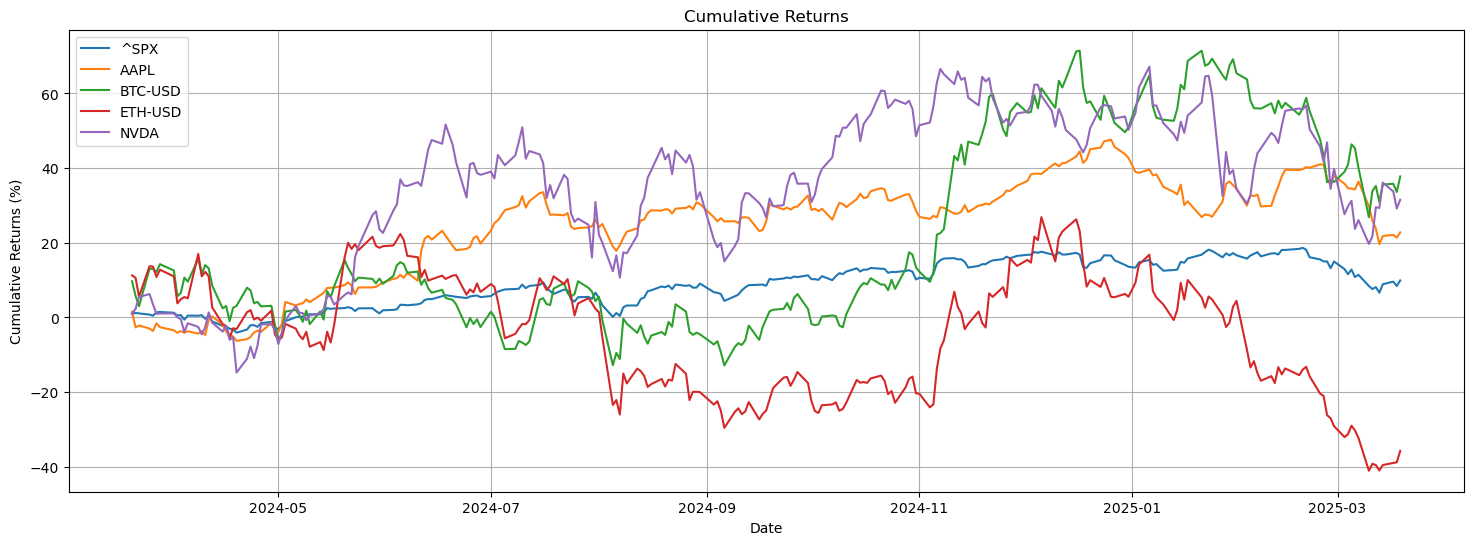

In [7]:
plt.figure(figsize=(18,6))

for col in cum_rets.columns:
    plt.plot(cum_rets.index, cum_rets[col], label=col)

plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
sigma = cov_matrix = daily_rets.cov()
sigma

Ticker,^SPX,AAPL,BTC-USD,ETH-USD,NVDA
Ticker,,,,,
^SPX,0.000075,0.000072,0.000125,0.000172,0.000203
AAPL,0.000072,0.000245,0.000098,0.000151,0.000140
BTC-USD,0.000125,0.000098,0.001145,0.001200,0.000293
ETH-USD,0.000172,0.000151,0.001200,0.001869,0.000436
NVDA,0.000203,0.000140,0.000293,0.000436,0.001255


### 1. Relative View

Creating a view-matrix, P, to say: SPY will underperform aapl, nvda, and will outperform btc and eth

In [9]:
P1 = np.array([
    [1,  0,  0,  0,  0],
    [-1, 1,  0,  0,  0],
    [1,  0, -1,  0,  0],
    [1,  0,  0, -1,  0],
    [-1,  0,  0,  0, 1]
])

In [10]:
omega = np.diag(np.diag(P1.T @ sigma @ P1))
omega

array([[0.00535955, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.000245  , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.00114545, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.00186898, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00125456]])

In [11]:
Q = np.array([mu[0], (mu[1] - mu[0]), (mu[0] - mu[2]), (mu[0] - mu[3]), (mu[4] - mu[0])])
print(f"mean return vector:", mu)
print()
print(f"Q vector:", Q)

mean return vector: [ 0.00041602  0.00094322  0.00184462 -0.00083898  0.00172955]

Q vector: [ 0.00041602  0.0005272  -0.0014286   0.00125501  0.00131353]


In [12]:
lam = 1.0

weights = np.linalg.inv(lam*sigma) @ mu 
weights.sum(), weights

(5.819887474889402,
 array([-0.67333678,  3.89922572,  6.33804223, -5.08533506,  1.34129136]))

In [13]:
lam_adj = np.ones(len(weights)) @ weights
weights_adj = np.linalg.inv(lam_adj*sigma) @ mu
weights_adj.sum(), weights_adj


# weights sum to whatever initial lambda was set to...

(1.0000000000000002,
 array([-0.11569584,  0.66998301,  1.08903175, -0.8737858 ,  0.23046689]))

Following He and Litterman and Idzorek, use the view adjusted means, variances, and covariances to compute w*

In [14]:
# Calculate mu* and sigma*

mu_star = np.linalg.inv(np.linalg.inv(sigma) + P1.T @ np.linalg.inv(omega) @ P1)  @  (np.linalg.inv(sigma) @ mu + P1.T @ np.linalg.inv(omega) @ Q)

sigma_star = np.linalg.inv(np.linalg.inv(sigma) + P1.T @ np.linalg.inv(omega) @ P1) + sigma 

print(f"mu*:", mu_star) 
print()
print()
print(f"sigma*:", sigma_star)

mu*: [ 0.00041602  0.00094322  0.00184462 -0.00083898  0.00172955]


sigma*: Ticker       ^SPX      AAPL   BTC-USD   ETH-USD      NVDA
Ticker                                                   
^SPX     0.000140  0.000137  0.000203  0.000278  0.000338
AAPL     0.000137  0.000412  0.000169  0.000256  0.000255
BTC-USD  0.000203  0.000169  0.001669  0.001648  0.000441
ETH-USD  0.000278  0.000256  0.001648  0.002724  0.000653
NVDA     0.000338  0.000255  0.000441  0.000653  0.001987


In [15]:
lambda_star = 1.0
w_star = np.linalg.inv(lambda_star*sigma_star) @ mu_star
w_star.sum(), w_star

(2.9272606468112947,
 array([-1.03950275,  2.36881508,  3.43963643, -2.71387592,  0.87218781]))

In [16]:
lambda_star_adj = np.ones(len(w_star)) @ w_star
w_star_adj = np.linalg.inv(lambda_star_adj*sigma_star) @ mu_star
w_star_adj.sum(), w_star_adj

(1.0000000000000002,
 array([-0.3551111 ,  0.80922588,  1.17503593, -0.9271043 ,  0.29795359]))

We maximize the sharp ratio of the BLM based on the following equations for weights: 

$$
\max_{\omega^*} \;\frac{\omega^{*^\prime}\,\mu^*}{\omega^{*^\prime}\,\Sigma^*\,\omega^*}
$$


In [17]:
def negative_sharpe(w, mu_star, sigma_star):
    """
    Computes the negative Sharpe ratio for a given portfolio allocation.

    Parameters:
    w (ndarray): A vector of portfolio weights (size n).
    mu_star (ndarray): A vector of expected returns for each asset (size n).
    sigma_star (ndarray): Covariance matrix of asset returns (n x n).
    
    rf (float): Risk-free rate of return.(For simplicity, assuming 3.5%)

    Returns:
    float: The negative Sharpe ratio of the portfolio. If the denominator 
           (variance) is too small, returns a large value to avoid division 
           errors.

    Purpose:
    The function is designed to be minimized by an optimizer to maximize the 
    Sharpe ratio of the portfolio.
    """
    rf = 0.00035
    numerator = w.T @ mu_star - rf
    denominator = w.T @ sigma_star @ w
    if denominator < 1e-12:
        return 1e12
    return -(numerator/denominator)



def constraint(w):
    """
    Enforces the equality constraint that portfolio weights must sum to 1.

    Parameters:
    w (ndarray): A vector of portfolio weights (size n).

    Returns:
    float: The difference between the sum of weights and 1.0. 
           If the sum equals 1, the function returns 0 (constraint satisfied).

    Purpose:
    Used as a constraint in optimization to ensure a valid portfolio allocation.
    """
    return np.sum(w)-1.0



def maximize_ratio(mu_star, sigma_star):
    """
    Optimizes portfolio weights to maximize the Sharpe ratio under constraints.

    Parameters:
    mu_star (ndarray): A vector of expected returns for each asset (size n).
    sigma_star (ndarray): Covariance matrix of asset returns (n x n).

    Returns:
    OptimizeResult: An object containing the optimization result. The optimized 
                    portfolio weights can be accessed via `result.x`.

    Optimization Details:
    - Objective Function: Minimizes the negative Sharpe ratio.
    - Constraints: 
        - Portfolio weights must sum to 1 (equality constraint).
        - No short-selling (weights bounded between 0 and 1).
    - Method: Sequential Least Squares Programming (SLSQP).

    Purpose:
    Finds the optimal portfolio allocation to maximize the Sharpe ratio while 
    adhering to the constraints.
    """
    n = len(mu_star)
    w0 = np.ones(n)/n  # initially guessing equal weighting
    bounds = [(0,1)]*n # no shorting
    constraints = [{'type': 'eq', 'fun': constraint}]

    result = minimize(fun = negative_sharpe,              # the objective function to minimize
                      x0 = w0,                            # initial guess of the weights
                      args = (mu_star, sigma_star),       # additional arguments to the objective function
                      method = 'SLSQP',                   # optimization method
                      bounds = bounds,                    # bounds for the weights
                      constraints = constraints,          # constraints for the optimization
                      options = {'disp': False}           # display optimization information
                      )
    return result

In [18]:
## Try it out now

res_rel = maximize_ratio(mu_star, sigma_star)
if res_rel.success:
    w_opt_rel = res_rel.x
    ratio_opt_rel = -res_rel.fun # negate because we minimized the negative ratio
    print(f"Optimal Weights:", w_opt_rel)
    print(f"Sum of weights = ", w_opt_rel.sum())
    print(f"Sharpe Ratio = ", ratio_opt_rel)
else:
    print("Optimization failed:", res_rel.message)

Optimal Weights: [0.25660483 0.47224706 0.18740555 0.         0.08374255]
Sum of weights =  1.000000000000214
Sharpe Ratio =  2.270847533737145


### 2. Absolute View. Using P = I = identity matrix

In [19]:
P2 = np.identity(5)
P2

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [20]:
omega2 = np.diag(np.diag(P2.T @ sigma @ P2))
omega2

array([[7.53726434e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 2.45004226e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.14544958e-03, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.86897749e-03,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.25455632e-03]])

In [21]:
### NEED NEW Q-VECTOR FOR THE ABSOLUTE VIEW MATRIX P = I 

Q2 = P2 @ mu  # just = mu because P2 is identity matrix
Q2

array([ 0.00041602,  0.00094322,  0.00184462, -0.00083898,  0.00172955])

In [22]:
# Calculate mu2* and sigma2*

mu_star2 = np.linalg.inv(np.linalg.inv(sigma) + P2.T @ np.linalg.inv(omega2) @ P2)  @  (np.linalg.inv(sigma) @ mu + P2.T @ np.linalg.inv(omega2) @ Q2)

sigma_star2 = np.linalg.inv(np.linalg.inv(sigma) + P2.T @ np.linalg.inv(omega2) @ P2) + sigma 

print(f"mu*(2):", mu_star2) 
print()
print()
print(f"sigma*(2):", sigma_star2)

mu*(2): [ 0.00041602  0.00094322  0.00184462 -0.00083898  0.00172955]


sigma*(2): Ticker       ^SPX      AAPL   BTC-USD   ETH-USD      NVDA
Ticker                                                   
^SPX     0.000104  0.000090  0.000145  0.000201  0.000255
AAPL     0.000090  0.000358  0.000103  0.000167  0.000151
BTC-USD  0.000145  0.000103  0.001589  0.001540  0.000314
ETH-USD  0.000201  0.000167  0.001540  0.002579  0.000484
NVDA     0.000255  0.000151  0.000314  0.000484  0.001800


In [23]:
res_abs = maximize_ratio(mu_star2, sigma_star2)
if res_abs.success:
    w_opt_abs = res_abs.x
    ratio_opt_abs = -res_abs.fun # negate because we minimized the negative ratio
    print(f"Optimal Weights:", w_opt_abs)
    print(f"Sum of weights = ", w_opt_abs.sum())
    print(f"Sharpe Ratio = ", ratio_opt_abs)
else:
    print("Optimization failed:", res_abs.message)

Optimal Weights: [3.54235591e-01 4.13004099e-01 1.53868035e-01 2.92749148e-14
 7.88922749e-02]
Sum of weights =  1.0
Sharpe Ratio =  2.895542196571407


# Investment Report

### Data

The data was collected from YahooFinance. One year of daily price data was collected for the S&P500, Apple, Bitcoin, Ethereum, and Nvidia.

### Methodology

The methods of the Black-Litterman model were used in an attempt to address the challenges/shortfalls of the traditional mean-variance optimization/Markowitz-Model. BLM was designed to solve the problem of hypersensitivity of portfolio weights in reaction to a minor change in input estimates. It also allows the investor to implement both subjective, or absolute views on expected returns which have large implications on portfolio allocation. The model leads with Market Equilibrium Returns, ie the implied returns based on the global market portfolio and its weights. Using historical data, mean returns, cumulative returns, as well as a covariance matrix(sigma) of the asset returns. The BLM approach then allows the investor to implement their own subjective/absolute views on the portfolio. In this project, views are expressed using matrices(P-matrices) that code the respective views. An absolute view would look something like "Asset X will return 5%" while a relative view would be expressed as "Asset X will outperform Asset Y by 3%". Then, a vector of expected returns/performance differentials is calculated(Q-vector) based on the relative/absolute views. The investor will be able to quantify the uncertainty of their views by creating a diagonal matrix(Q) that represents the confidence in each view. Within this diagonal matrix, larger values represent greater uncertainty, while all non-diagonal values are zero, due to independence. Using these inputs, posterior returns (the equilibrium returns adjusted by investor views), mu* are calculated which are used to optimize mean-variance in determining optimal portfolio weights. 

### Assumptions of the Black-Litterman Model 

 1. Market Efficiency: The global market portfolio represents an equilibrium state. thus its returns are used as a neutral starting point. 

 2. Distribution of Asset Returns: Asset returns and investor views are assumed to follow a multivariate normal distribution. 

 3. Independence of Views: Views are independent of the market equilibrium returns

 4. Uncertainty in Views is Quantifiable: The model assumes that the uncertainty of each view can be expressed numerically, allowing for a weighted combination of views and market equilibrium. 

## a. Relative View weights and Sharpe Ratio

In [24]:
print(f"Optimal Weights:", w_opt_rel)
print(f"Sharpe Ratio: ", ratio_opt_rel)

Optimal Weights: [0.25660483 0.47224706 0.18740555 0.         0.08374255]
Sharpe Ratio:  2.270847533737145


The implemented relative view was that SPY would outperform BTC and ETH, and underperform AAPL and NVDA. Most of the allocation is in the SP500, likely due to the lower variability seen in historical returns, while still achieving a high RoR over the specified time period. 

## b. Absolute View weights and Sharpe Ratio

In [25]:
print(f"Optimal Weights:", w_opt_abs)
print(f"Sharpe Ratio: ", ratio_opt_abs)

Optimal Weights: [3.54235591e-01 4.13004099e-01 1.53868035e-01 2.92749148e-14
 7.88922749e-02]
Sharpe Ratio:  2.895542196571407


The implemented absolute view stated that the expected returns were nothing but the mean returns for each respective asset. The sharpe ratio when implementing an absolute view > that for a relative view. This means we have more efficient risk-taking when implementing the absolute view, however, using an absolute view may not actually prouce a superior sharpe ratio. 

The largest weight of the portfolio was allocated to the S&P500, again, likely due to the return efficiency with respect to the risk of the position. The S&P was extremely stable when compared to the other assets, especially NVDA, BTC, and ETH. It may not be good practice here to mix Equities with highly volatile cryptocurrencies, however, the selected equities were certainly more volatile than most other equities in the market. 

What we end up seeing in both approaches is a large allocation to the S&P500, and Apple, with modestly decreasing allocation to BTC, and NVDA. with zero allocation to ethereum in both view implementations. On that scale, the assets increase in variance, making them inherently riskier to hold in future periods. However, the returns are excellent, especially over the specified time period, which is why we still continue to see a small allocation to the riskier assets(BTC,NVDA), because their returns justify a small allocation. 